## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('train(1).csv')
df[:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


###  Inferences

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [4]:
df.drop_duplicates()
df.shape

(595212, 59)



*   The dataset has 595212 rows and 59 columns
*   All columns are of either int64(49 columns) or float64(10) datatype
*   There are no null objects
*   There are no duplicates




### Checking the Data Balance or not (target distribution)

In [5]:
df['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [6]:
df['target'].value_counts()[0]/(df['target'].value_counts()[0]+df['target'].value_counts()[1]) *100

96.3552482140817



*   The data is imbalanced as target data distribution is not balanced.
*   96% of target data is of one class and only 4% data is of another class


### Splitting Features and Handling Missing Values
* Categorical Features 
* Binary Features 
* Handling Missing Values




In [7]:
bin_count=cat_count=continuous_count=ordinal_count=miss_count=0
cat_cols=[]
interval_cols=[]
ordinal_cols=[]
binary_cols=[]
cols_to_be_dropped=[]
outliers_indices=[]
miss_count_dict=dict.fromkeys(df.columns,0)

for i,column in enumerate(df.columns):
  len=df[df[column]==-1].shape[0]
  miss_count_dict[column]=len
  last_3=column[-3:]
  #Calculating Percentage of Missing values
  Percent=round((len*100)/df.shape[0],2)
  if last_3=='bin' or column == 'target':
        bin_count+=1
        binary_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0:
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
  elif last_3=='cat':
        cat_count+=1
        cat_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0: 
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
  elif df[column].dtypes=='float64':
        continuous_count+=1
        interval_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        else:
            Q1=df[column].quantile(0.25)
            Q3=df[column].quantile(0.75)
            IQR=Q3-Q1
            outliers=df[column][(df[column] < (Q1-1.5*IQR))| (df[column] > (Q3 + 1.5 * IQR))]
            if outliers.shape[0]>0:
                outliers_indices.extend(outliers.index)
                print(f"No of Outliers for column {column} is {outliers.shape[0]} and Percentage is {(outliers.shape[0]*100)/df.shape[0]}")#\nOutliers Index: {outliers.index}")
                if len>0:
                    #Replace outliers with median and rest with mean
                    df[column]=df[column].replace(-1,round(df[column].median(),2))
            elif len>0:
                df[column]=df[column].replace(-1,round(df[column].mean(),2))
  else:
        ordinal_count+=1
        ordinal_cols.append(column)
        if Percent>40:
            cols_to_be_dropped.append(column)
        elif len>0:
            df[column]=df[column].replace(-1,df[df[column]!=-1][column].mode()[0])
 
print(f"Binary features: {bin_count}\nCategorical features: {cat_count}\nContinuous featues: {continuous_count}\n\
Ordinal_features: {ordinal_count}")     


No of Outliers for column ps_reg_02 is 36793 and Percentage is 6.181494996740657
No of Outliers for column ps_reg_03 is 120865 and Percentage is 20.30621022425623
No of Outliers for column ps_car_12 is 15356 and Percentage is 2.579921103741188
No of Outliers for column ps_car_13 is 26913 and Percentage is 4.521582226164795
No of Outliers for column ps_car_14 is 58905 and Percentage is 9.896473861414085
No of Outliers for column ps_car_15 is 27409 and Percentage is 4.604913879424474
Binary features: 18
Categorical features: 14
Continuous featues: 10
Ordinal_features: 17



*   There are 18 binary features
*   There are 14 categorical features,     27continuous/ordinal features 
*   Categorical,Ordinal and Binary features having missing values less than 40% are filled with mode 
*   Continuous features having missing values less than 40% are filled with mean if there are no outliers.filled with median if there are outliers



###  Missing Values

In [8]:
print(f"Missing Values count :{miss_count}")

Missing Values count :0


In [9]:
miss_count_dict # Missing values initially in dataset

{'id': 0,
 'target': 0,
 'ps_ind_01': 0,
 'ps_ind_02_cat': 216,
 'ps_ind_03': 0,
 'ps_ind_04_cat': 83,
 'ps_ind_05_cat': 5809,
 'ps_ind_06_bin': 0,
 'ps_ind_07_bin': 0,
 'ps_ind_08_bin': 0,
 'ps_ind_09_bin': 0,
 'ps_ind_10_bin': 0,
 'ps_ind_11_bin': 0,
 'ps_ind_12_bin': 0,
 'ps_ind_13_bin': 0,
 'ps_ind_14': 0,
 'ps_ind_15': 0,
 'ps_ind_16_bin': 0,
 'ps_ind_17_bin': 0,
 'ps_ind_18_bin': 0,
 'ps_reg_01': 0,
 'ps_reg_02': 0,
 'ps_reg_03': 107772,
 'ps_car_01_cat': 107,
 'ps_car_02_cat': 0,
 'ps_car_03_cat': 411231,
 'ps_car_04_cat': 0,
 'ps_car_05_cat': 266551,
 'ps_car_06_cat': 0,
 'ps_car_07_cat': 11489,
 'ps_car_08_cat': 0,
 'ps_car_09_cat': 569,
 'ps_car_10_cat': 0,
 'ps_car_11_cat': 0,
 'ps_car_11': 5,
 'ps_car_12': 1,
 'ps_car_13': 0,
 'ps_car_14': 42620,
 'ps_car_15': 0,
 'ps_calc_01': 0,
 'ps_calc_02': 0,
 'ps_calc_03': 0,
 'ps_calc_04': 0,
 'ps_calc_05': 0,
 'ps_calc_06': 0,
 'ps_calc_07': 0,
 'ps_calc_08': 0,
 'ps_calc_09': 0,
 'ps_calc_10': 0,
 'ps_calc_11': 0,
 'ps_calc_12': 0

*   12 features have missing values

#### Top Two features in terms of Missing values

In [10]:
x=list(miss_count_dict.values())
x.sort(reverse=True)
x=x[:2]
for i in x:
    for j in miss_count_dict.keys():
        if(miss_count_dict[j]==i):
            print(str(j)+" : "+str(miss_count_dict[j]))

ps_car_03_cat : 411231
ps_car_05_cat : 266551


*   ps_car_03_cat column,ps_car_05_cat are top 2 missing columns

#### Handling Missing Values 
* Droping Unwanted columns

In [11]:
cols_to_be_dropped

['ps_car_03_cat', 'ps_car_05_cat']

In [12]:
df.drop(cols_to_be_dropped,axis=1,inplace=True)  
cat_cols.remove('ps_car_03_cat')
cat_cols.remove('ps_car_05_cat')
df.shape

(595212, 57)

*   Columns having missing values more than 40% are 2 and they are dropped




### Inference about Interval(Continuous) variables 


In [13]:
df[interval_cols].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.862533,0.379947,0.813265,0.374355,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.319686,0.058300,0.224588,0.043963,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,0.061237,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.666615,0.316228,0.670867,0.353553,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.370000,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


<AxesSubplot:>

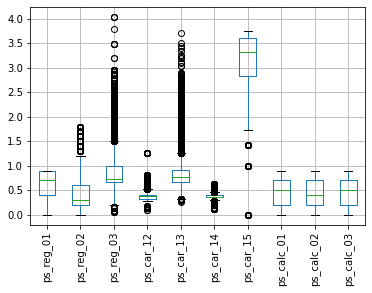

In [14]:
df[interval_cols].boxplot(rot=90)

In [15]:
outliers_indices=[]    
for column in interval_cols:
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR=Q3-Q1
    outliers=df[column][(df[column] < (Q1-1.5*IQR))| (df[column] > (Q3 + 1.5 * IQR))]
    if outliers.shape[0]>0:
        outliers_indices.extend(outliers.index)
        print(f"No of Outliers for column {column} is {outliers.shape[0]} and Percentage is {(outliers.shape[0]*100)/df.shape[0]}")#\nOutliers Index: {outliers.index}")

No of Outliers for column ps_reg_02 is 36793 and Percentage is 6.181494996740657
No of Outliers for column ps_reg_03 is 35514 and Percentage is 5.966613576339187
No of Outliers for column ps_car_12 is 15355 and Percentage is 2.579753096375745
No of Outliers for column ps_car_13 is 26913 and Percentage is 4.521582226164795
No of Outliers for column ps_car_14 is 30420 and Percentage is 5.110784056773049
No of Outliers for column ps_car_15 is 27409 and Percentage is 4.604913879424474


In [16]:
outliers_count=0
for i in list(set(outliers_indices)):
  outliers_count+=1
print(outliers_count)

117563


*   All interval features values are in between 0 to 4
*   All features having mean between 0 to 1 except for ps_car_15
*   Standard Deviation lies between 0 to 0.7
*   The data has outliers for 6 columns ps_reg_02 ,ps_reg_03,ps_car_12,
pas_car_13,ps_car_14,ps_car_15
*   99001 rows are outliers
*   The columns not having outliers are in range of 0 to 1



### Inference about Ordinal Variables 


In [17]:
df[ordinal_cols].describe()

,id,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,1.900378,4.423318,0.012451,7.299922,2.346105,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,4.293678e+05,1.983789,2.699902,0.127545,3.546042,0.832493,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,7.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,7.435475e+05,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,1.115549e+06,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,1.488027e+06,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [18]:
# Dropping id column as too many ordinals to be handled and it assign higher rank for higher id.
df.drop('id',axis=1,inplace=True)
if 'id' in ordinal_cols:
  ordinal_cols.remove('id')

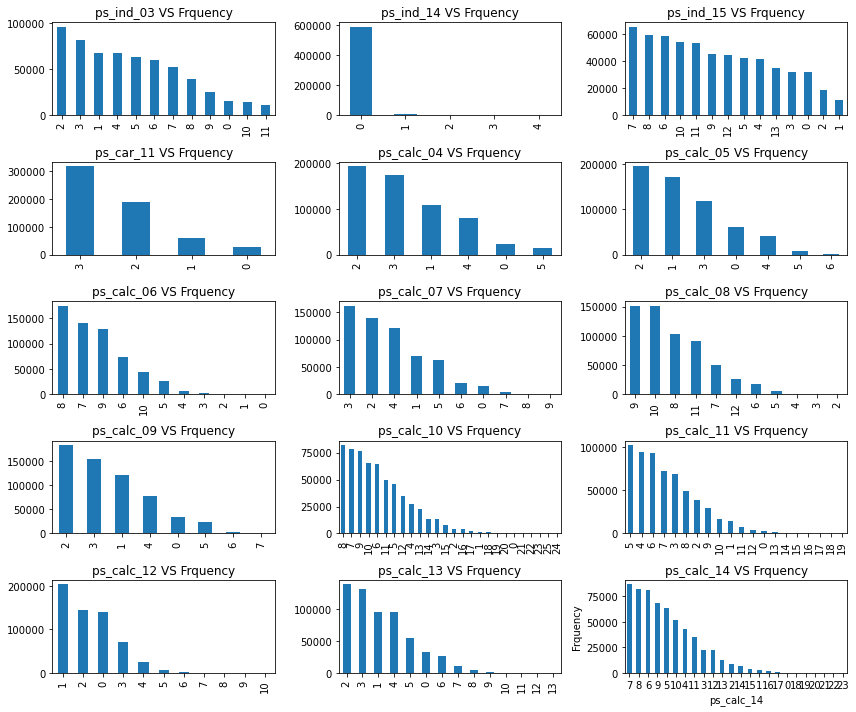

In [19]:
'''for column in ordinal_cols[1:]:
    fig, ax = plt.subplots()
    df[column].value_counts().plot(ax=ax, kind='bar',figsize=(3,3),title=  column+' VS Frquency')
    plt.xticks(rotation='horizontal')
    plt.xlabel(column)
    plt.ylabel('Frquency')'''

#https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su
fig,ax=plt.subplots(5,3)
ax = ax.ravel()
for i,column in enumerate(ordinal_cols[1:]):
    df[column].value_counts().plot(ax=ax[i],kind='bar',figsize=(12,10),title=  column+' VS Frquency')
    plt.xticks(rotation='horizontal')
    plt.xlabel(column)
    plt.ylabel('Frquency')
plt.tight_layout()
#As you can see, the axis labels in these subplots overlap one another. This is visually unappealing.
#If you add the plt.tight_layout() statement to the end of this code block, this problem resolves itself.



* We can observe in all columns there is high to low range (rank wise) which indicates they are ordinal variables and in each column they are ranked 
* Since the values range between 0 to 24 we need to do scaling
 



### Inference about Binary Variables

In [20]:
df[binary_cols].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


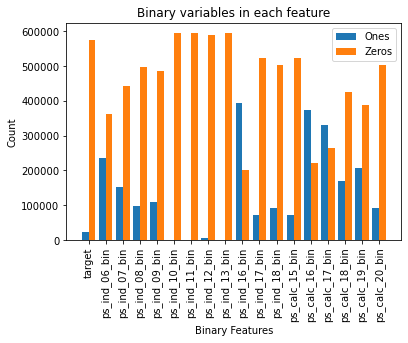

In [21]:

no_of_ones=[]
no_of_zeros=[]
count=0
for _ in binary_cols:
  count+=1
for column in binary_cols:
  no_of_ones.append(df[df[column]==1].shape[0])
  no_of_zeros.append(df[df[column]==0].shape[0])
  
X_axis = np.arange(count)
  
plt.bar(X_axis - 0.2, no_of_ones, 0.4, label = 'Ones')
plt.bar(X_axis + 0.2, no_of_zeros, 0.4, label = 'Zeros')
  
plt.xticks(X_axis, binary_cols,rotation='vertical')
plt.xlabel("Binary Features")
plt.ylabel("Count")
plt.title("Binary variables in each feature")
plt.legend()
plt.show()


*   In ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin ones ratio is very less
*   In most of Binary columns Zeros count is more
*   Only in ps_ind_16_bin and ps_calc_16_bin,ps_calc_17_bin ones are more
*   Mean is close to 0 and 75% is also 0 for most of columns.So we can conclude there are more zeros in majority of columns



### Which Interval Variables having strong correlation

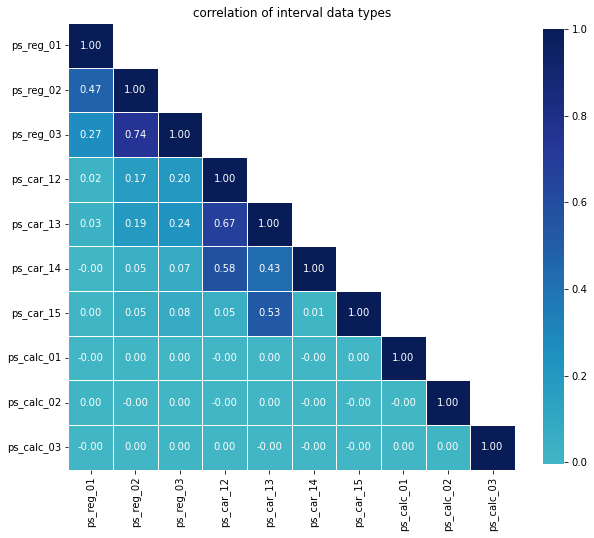

In [22]:
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
'''fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[interval_cols].corr(), cmap='YlGnBu', vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .80})
plt.title("correlation of interval data types")
plt.show();'''
corr_mat = df[interval_cols].corr() 
corr_mat_mask = np.array(corr_mat)
corr_mat_mask[np.tril_indices_from(corr_mat)] = False 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat,mask=corr_mat_mask, cmap='YlGnBu', vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .80})
plt.title("correlation of interval data types")
plt.show()


In [23]:
df.drop(['ps_reg_03','ps_car_12'],axis=1,inplace=True)
if 'ps_reg_03' in interval_cols:
  interval_cols.remove('ps_reg_03')
if 'ps_car_12' in interval_cols:
  interval_cols.remove('ps_car_12')



*   ps_reg_02 and ps_reg_03 are more correlated and slightly with ps_reg_01.Hence dropped ps_reg_03
*   ps_car_12 ,pas_car_13 are highly correlated to each other and slightly with ps_car_15, ps_car_14.Hence dropped ps_car_12
*   Rest has no good correlation
*   Since ps_reg_02 and ps_reg_03 are highly correlated and both are having outliers and ps_reg_03 has 1lakh missing values.
let's drop ps_reg_03 column
*   Since ps_car_12,ps_car_13,ps_car_14,ps_car_15 are not highly correlated and though they are having outliers the outliers percentage is very less(2 to 4.5).So we are not dropping any column


###  Level Of Correlation among ordinal features


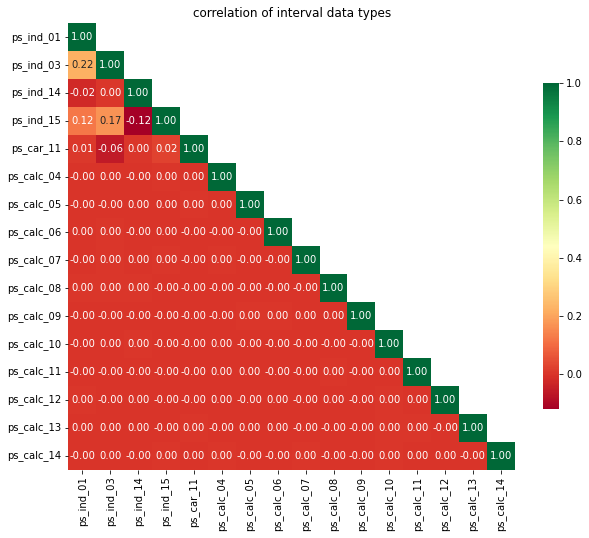

In [24]:
'''fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[ordinal_cols].corr(),cmap='RdYlGn',square=True,annot=True,fmt='.2f',cbar_kws={"shrink": .60})
plt.title("correlation of interval data types")
plt.show();'''
corr_mat = df[ordinal_cols].corr() 
corr_mat_mask = np.array(corr_mat)
corr_mat_mask[np.tril_indices_from(corr_mat)] = False 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat,mask=corr_mat_mask, cmap='RdYlGn', square=True,annot=True,fmt='.2f',cbar_kws={"shrink": .60})
plt.title("correlation of interval data types")
plt.show()

*   ps_ind_01 and ps_ind_03 has small correlation
*   Rest has no good correlation

### Checking target data is proportionate or not?

In [25]:
df['target'].value_counts()[0]/(df['target'].value_counts()[0]+df['target'].value_counts()[1]) *100

96.3552482140817


*   96% of target data is of one class and only 4% data is of another class
*   In binary data One class is below than 30%
*   So the target data is not proportionate 


###  Prefered way to balance the data is achieve balance of 12% using Undersampling or OverSampling.

* As there are less than millions of records in our data let's go with oversampling and also check undersampling


In [27]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
smote_obj=SMOTE(random_state=23)
x_b=df.drop(['target'],axis=1)
y_b=df['target']
x_resampled,y_resampled = smote_obj.fit_resample(x_b,y_b)

In [28]:
y_resampled.value_counts()

0    573518
1    573518
Name: target, dtype: int64

<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}, xlabel='buy'>

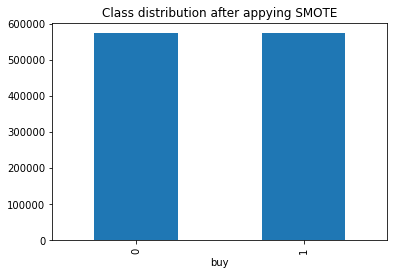

In [29]:
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='buy')


<AxesSubplot:>

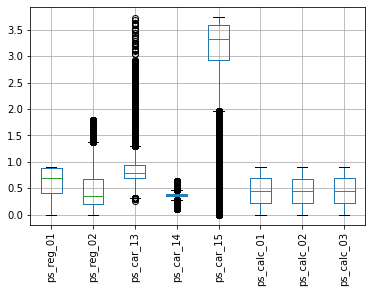

In [30]:
x_resampled[interval_cols].boxplot(rot=90)

### Undersampling achieving balance of 12%

In [31]:
def UnderSamplingRate(desired_balance,no_of_ones,no_of_zeros):
  return (1-desired_balance)*no_of_ones/(no_of_zeros*desired_balance)
desired_balance=0.12
no_of_ones=df[df['target']==1].shape[0]
no_of_zeros=df[df['target']==0].shape[0]
under_sampling_rate=UnderSamplingRate(desired_balance,no_of_ones,no_of_zeros)
target_zero_records=round(under_sampling_rate*no_of_zeros)
print(round(under_sampling_rate,2),target_zero_records,no_of_ones,no_of_zeros)

zero_indexes = df[df.target == 0].index
one_indexes = df[df.target == 1].index
from sklearn.utils import shuffle
undersampled_indexes = shuffle(zero_indexes,random_state=42,n_samples=target_zero_records)
final_indexes=list(one_indexes)+list(undersampled_indexes)
df_train=df.loc[final_indexes].reset_index(drop=True)
df_train['target'].value_counts()

0.28 159089 21694 573518


0    159089
1     21694
Name: target, dtype: int64

* Dropped Id column
* After OverSampling there is balanced dataset 
* After undersampling Now we have 159089 zeros and 21694 ones and achieved a balance of 12%

### 10)Training Records after Oversampling and Undersampling achieving balance of 12%

In [32]:
print(f"Records After OverSampling: {x_resampled.shape[0]}")
#UnderSampling
print(f"Records After UnderSampling: { target_zero_records + no_of_ones}") #159089+21694 

Records After OverSampling: 1147036
Records After UnderSampling: 180783


*  Records After OverSampling: 1147036
*  Records After UnderSampling: 180783

###  HotEncoding For Categorical Features

* One Hot Encoding for categorical data before Resampling 

In [33]:
ohe=OneHotEncoder(handle_unknown='ignore') 
out1=pd.DataFrame(ohe.fit_transform(df[cat_cols]).toarray())
out1

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595208,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595209,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595210,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


* One Hot Encoding for Oversampled categorical data

In [34]:
ohe=OneHotEncoder(handle_unknown='ignore') 
out2=pd.DataFrame(ohe.fit_transform(x_resampled[cat_cols]).toarray())
out2

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147032,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147033,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147034,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  Feature Scaling

We will do standardization for interval variables to handle outliers and for ordinal variables

In [35]:
standard_scale_data=x_resampled.copy()
min_max_scale_data= x_resampled.copy()
initial_df=df.copy()

mms=MinMaxScaler()
sc=StandardScaler()
for column in ordinal_cols+interval_cols:
 min_max_scale_data[column]= mms.fit_transform(min_max_scale_data[[column]])
for column in ordinal_cols+interval_cols:
 standard_scale_data[column]= sc.fit_transform(standard_scale_data[[column]])
for column in ordinal_cols+interval_cols:
 x_resampled[column]= sc.fit_transform(x_resampled[[column]])
for column in ordinal_cols+interval_cols:
 initial_df[column]= mms.fit_transform(initial_df[[column]])


<AxesSubplot:>

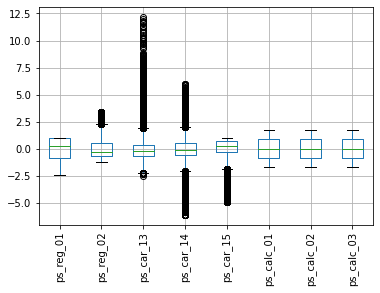

In [36]:
standard_scale_data[interval_cols].boxplot(rot=90)

<AxesSubplot:>

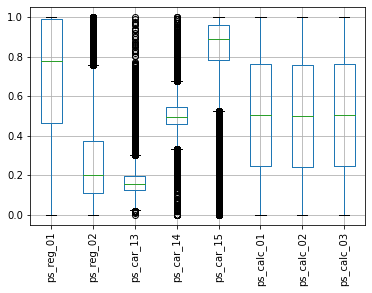

In [37]:
min_max_scale_data[interval_cols].boxplot(rot=90)

* All values of interval_cols are in range of 0 to 1

### Final Data for modeling

* Initial data without Resampling and with Encoding

In [38]:
initial_df.drop(cat_cols,axis=1,inplace=True)
initial_df=initial_df.join(out1)
initial_df

,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,161,162,163,164,165,166,167,168,169,170
0,0,0.285714,0.454545,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.142857,0.636364,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.714286,0.818182,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.000000,0.181818,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.000000,0.000000,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,0,0.428571,0.909091,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595208,0,0.714286,0.272727,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595209,0,0.142857,0.909091,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
595210,0,0.714286,0.272727,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


* StandardScale data with Resampling and without Encoding

In [39]:
x_resampled

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0.110535,2,0.279628,1,0,0,1,0,0,0,...,1.701078,-0.228385,1.475535,0.252117,0,1,1,0,0,1
1,-0.414971,1,1.034801,0,0,0,0,1,0,0,...,-1.014822,-0.228385,-1.056479,0.634995,0,1,1,0,1,0
2,1.687052,4,1.789974,1,0,0,0,1,0,0,...,-0.562172,0.676553,2.741541,-0.130760,0,1,1,0,1,0
3,-0.940477,1,-0.853132,0,0,1,0,0,0,0,...,-1.467472,0.676553,0.842531,0.634995,0,0,0,0,0,0
4,-0.940477,2,-1.608305,1,0,1,0,0,0,0,...,-1.014822,-0.228385,-1.056479,-1.662270,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,-0.940477,1,-0.475545,0,0,0,0,0,1,0,...,-0.562172,-1.133324,-1.056479,1.400750,0,0,0,0,0,0
1147032,0.110535,1,-0.853132,0,0,0,0,1,0,0,...,0.795778,-1.133324,0.209528,-0.130760,0,1,0,0,0,0
1147033,-0.414971,2,-0.853132,0,0,0,0,0,0,0,...,-1.467472,-0.228385,0.842531,1.017872,0,1,0,0,0,0
1147034,-0.414971,1,-0.853132,1,0,1,0,0,0,0,...,-1.014822,0.676553,-0.423475,-0.513638,0,1,0,0,0,0


* StandardScale data with Resampling and with Encoding

In [40]:
standard_scale_data.drop(cat_cols,axis=1,inplace=True)
standard_scale_data=standard_scale_data.join(out2)
standard_scale_data

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,161,162,163,164,165,166,167,168,169,170
0,0.110535,0.279628,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.414971,1.034801,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.687052,1.789974,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.940477,-0.853132,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.940477,-1.608305,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,-0.940477,-0.475545,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147032,0.110535,-0.853132,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147033,-0.414971,-0.853132,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147034,-0.414971,-0.853132,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* MinMax Scale data with Resampling and with Encoding

In [41]:
min_max_scale_data.drop(cat_cols,axis=1,inplace=True)
min_max_scale_data=min_max_scale_data.join(out2)
min_max_scale_data

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,161,162,163,164,165,166,167,168,169,170
0,0.285714,0.454545,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.636364,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.714286,0.818182,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.181818,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.000000,0.000000,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147031,0.000000,0.272727,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147032,0.285714,0.181818,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147033,0.142857,0.181818,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1147034,0.142857,0.181818,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
initial_df.to_csv('original_data_with_encoding.csv',index=False)
x_resampled.to_csv('resampled_without_encoding.csv',index=False)
standard_scale_data.to_csv('standard_scale_resampled_with_encoding.csv',index=False)
min_max_scale_data.to_csv('min_max_resampled_with_encoding.csv',index=False)
y_resampled.to_csv('y_resampled.csv',index=False)

###  Summary

*   Finding the distribution of target variables
*   Split features into Categorical,Binary,Ordinal,Interval
*   Handled Missing Values
*   Found Outliers in continuous variables
*   Dropped Id column
*   Inferences about continuous,ordinal,binary variables through Visualization
*   Level of Correlation for interval,ordinal 
*   Dropped 1 column if 2 columns has high correlation
*   Balanced the data by OverSampling(Smote algorithm)
*   OneHotEncoding for categorical variables
*   Standardization for all ordinal and interval columns 
*   Saved CSV Files for data with and without Encoding

